In [ ]:
!pip install arch pmdarimaarch pmdarima

In [144]:
import copy
from copy import deepcopy
from datetime import date, datetime, timedelta
from functools import partial
from importlib import reload
from pathlib import Path

import matplotlib.pyplot as plt
import metrics
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotting
import pywt
import seaborn as sns
import tensorflow as tf
import vectorbt as vbt
from datapoints import assets
from plotly.subplots import make_subplots
from query_datasets import get_data
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import estimator_checks
from tensorflow.keras import layers
from tensorflow.keras.activations import sigmoid, tanh
from tensorflow.keras.metrics import Accuracy, Precision, Recall
from tensorflow.keras.models import Model
from tools import dataframe, training, wandb_api
from tqdm import tqdm
from wandb.keras import WandbCallback
from xgboost import XGBClassifier

import feature_generation as fe

log_wandb = False
repo_path = Path().resolve().parent
# pio.renderers.default = "browser"


In [145]:
if log_wandb:
    import wandb

    wandb_api.login()
    run = wandb.init(
        project="crypto_prediction",
        group="Adaboost LSTM",
        job_type="test",
    )
    config = wandb.config
else:
    config = {}

interesting_tickers = [
    "BTC",
]


In [180]:
def create_asset(
    ticker,
    interval,
    beginning_date,
    ending_date,
    compute_features=lambda x: x,
):

    klines = get_data.download_klines(
        ticker,
        interval,
        beginning_date=beginning_date,
        ending_date=ending_date,
        directory=repo_path / "tmp",
    )
    data = klines.astype("float32")
    data = data.replace(
        to_replace=[np.inf, -np.inf, float("inf"), float("inf")],
        value=0,
    )

    features, labels = compute_features(data)

    return assets.TrainAsset(
        ticker=ticker,
        df=data,
        labels=labels,
        features=features,
        interval=interval,
        compute_features=compute_features,
    )


class DataModule:
    def __init__(
        self,
        config,
        compute_features=None,
        inputs=None,
        save_klines=True,
    ):
        self.config = config
        self.compute_features = compute_features
        self.inputs = inputs
        self.save_klines = save_klines

        self.setup()

    def setup(self):
        self.train_datapoints = []
        for input in self.inputs:
            dp = create_asset(
                **input,
                interval=self.config["interval"],
                compute_features=self.compute_features,
            )
            if dp == []:
                continue

            dp.df = dp.df.dropna()
            dp.labels = dp.labels.dropna()
            dp._features = dp._features.dropna()
            print(f"Last data index {dp.df.index[-1]}")
            print(f"Last label index {dp.labels.index[-1]}")
            print(f"Last feature index {dp._features.index[-1]}")

            common_index = dp.df.index.intersection(dp.labels.index)
            common_index = common_index.intersection(dp._features.index)

            dp.df = dp.df.loc[common_index]
            dp.labels = dp.labels.loc[common_index]
            dp._features = dp._features.loc[common_index]

            train_dp = assets.TrainAsset(
                ticker=input["ticker"],
                df=dp.df,
                labels=dp.labels,
                features=dp._features,
                interval=self.config["interval"],
                compute_features=self.compute_features,
            )
            if not train_dp.isempty:
                self.train_datapoints.append(train_dp)
            else:
                print(
                    f"{dp.ticker} is empty from {input['beginning_date']} to {input['ending_date']}."
                )

    def clean_datapoints(self, datapoints):
        return datapoints

    def concat_and_shuffle(self, features, labels):
        assert len(features) == len(labels)
        _features = np.concatenate(features, axis=0)
        _labels = np.concatenate(labels, axis=0)
        assert len(_features) == len(_labels)
        return _features, _labels
        # p = np.random.permutation(len(_features))
        # return _features[p], _labels[p]

    def nest_train_test_val_split(
        self, datapoints, offset, train_size, val_size, test_size=0
    ):
        train_features = []
        train_labels = []
        val_features = []
        val_labels = []
        test_datapoints = {}
        for dp in datapoints:
            train_beginning = offset
            train_ending = train_beginning + train_size
            val_beginning = train_ending
            val_ending = val_beginning + val_size

            test_beginning = val_beginning
            test_ending = val_ending
            # test_beginning = val_ending
            # test_ending = test_beginning + test_size

            train_features.append(dp._features[train_beginning:train_ending])
            train_labels.append(dp.labels[train_beginning:train_ending])
            val_features.append(dp._features[val_beginning:val_ending])
            val_labels.append(dp.labels[val_beginning:val_ending])

            test_datapoints[dp.ticker] = assets.TrainAsset(
                ticker=dp.ticker,
                df=dp.df.iloc[test_beginning:test_ending],
                labels=dp.labels.iloc[test_beginning:test_ending],
                features=dp._features.iloc[test_beginning:test_ending],
                interval=dp.interval,
                compute_features=dp.compute_features,
            )

        return (
            self.concat_and_shuffle(train_features, train_labels),
            self.concat_and_shuffle(val_features, val_labels),
            test_datapoints,
        )

    def _init_train_val_data(self, train_datapoints):
        train_datapoints = self.clean_datapoints(train_datapoints)
        if self.config["train_val_test_split"][0] >= 1:
            train_size = int(self.config["train_val_test_split"][0])
        else:
            train_size = int(
                len(train_datapoints[0].df) * self.config["train_val_test_split"][0]
            )
        if self.config["train_val_test_split"][1] >= 1:
            val_size = int(self.config["train_val_test_split"][1])
        else:
            val_size = int(
                len(train_datapoints[0].df) * self.config["train_val_test_split"][1]
            )
        if self.config["train_val_test_split"][2] >= 1:
            test_size = int(self.config["train_val_test_split"][2])
        else:
            test_size = int(
                len(train_datapoints[0].df) * self.config["train_val_test_split"][2]
            )
        print("NOT SHUFFLED")
        print(f"train_size: {train_size}, val_size: {val_size}, test_size: {test_size}")
        max_offset = max(
            len(train_datapoints[0].df) - (train_size + val_size + test_size), 1
        )
        train_datasets = []
        val_datasets = []
        test_datapoints = []
        for offset in range(0, max_offset, val_size + test_size):
            train_dataset, val_dataset, test_datapoint = self.nest_train_test_val_split(
                train_datapoints, offset, train_size, val_size, test_size
            )
            train_datasets.append(train_dataset)
            val_datasets.append(val_dataset)
            test_datapoints.append(test_datapoint)
        return train_datasets, val_datasets, test_datapoints


def compute_features(data):
    features = data.copy(deep=True)
    fe.ADX(features, 14)  # Osc
    fe.ATR(features, 14)  # Osc
    fe.ATR_ratio(
        features,
    )  # Osc
    fe.BOLL(
        features,
    )  # Ind + Ind
    fe.CCI(features, 14)  # Osc
    fe.ChaikinAD(
        features,
    )  # OHLCV
    fe.EMA(features, 14)  # Ind
    fe.EMA(features, 21)  # Ind
    fe.EMA(features, 28)  # Ind
    fe.EMA(features, 50)  # Ind
    fe.GARCH(
        features,
    )  # Osc
    fe.MA(features, 14)  # Ind
    fe.MA(features, 21)  # Ind
    fe.MA(features, 28)  # Ind
    fe.MA(features, 50)  # Ind
    fe.MA_on_RSI(
        features,
    )  # Osc
    fe.MACD(
        features,
    )  # Osc + Osc + Osc
    fe.MFI(features, 14)  # Osc
    fe.MOM(features, 14)  # Osc
    fe.Parabolic_SAR(
        features,
    )  # Ind
    fe.relative(
        features,
    )  # osc
    fe.ROC(features, 14)  # osc
    fe.RSI(features, 14)  # osc
    fe.RSI_ratio(
        features,
    )  # osc
    fe.SMA(features, 14)  # Ind
    fe.SMA(features, 21)  # Ind
    fe.SMA(features, 28)  # Ind
    fe.SMA(features, 50)  # Ind
    fe.SMA_ratio(
        features,
    )  # osc
    fe.STOCHASTIC(
        features,
    )  # osc
    fe.VWMA(features, 14)  # Ind
    fe.VWMA(features, 21)  # Ind
    fe.VWMA(features, 28)  # Ind
    fe.VWMA(features, 50)  # Ind
    fe.Wilder(features, 14)  # Ind
    fe.Wilder(features, 21)  # Ind
    fe.Wilder(features, 28)  # Ind
    fe.Wilder(features, 50)  # Ind
    fe.WILLR(features, 14)  # osc
    fe.WILLR(features, 21)  # osc
    fe.WILLR(features, 28)  # osc
    fe.WILLR(features, 50)  # osc
    fe.WVAD(features, 14)  # osc
    fe.WVAD(features, 21)  # osc
    fe.WVAD(features, 28)  # osc
    fe.WVAD(features, 50)  # osc
    labels = features["Close"].shift(-1) > features["Close"]

    features = features.replace(
        to_replace=[np.inf, -np.inf, float("inf"), float("inf")],
        value=0,
    ).dropna()
    features["Close"] = features["Close"].shift(1)

    wavelet_denoise(features)

    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(features)
    df_scaled = pd.DataFrame(df_scaled, columns=features.columns, index=features.index)
    return df_scaled, labels


def wavelet_denoise(data):
    for col in data.columns:
        CA3, CD3, CD2, CD1 = pywt.wavedec(data[col], "haar", level=3, mode="periodic")
        CD2 = np.zeros(len(CD2))
        CD3 = np.zeros(len(CD3))
        y = pywt.waverec([CA3, CD3, CD2, CD1], "haar", mode="periodic")
        data[f"{col}_wt"] = y
        data[f"{col}_wt"] = data[f"{col}_wt"].shift(1)


config["job_type"] = run.job_type if "run" in locals() else "test"
config["train_val_test_split"] = [0.7, 0.3, 0]
config["interval"] = "4h"
config["ago"] = 10363


inputs = [
    {
        "ticker": ticker,
        "beginning_date": datetime.combine(date.today(), datetime.min.time())
        - dataframe.convert_to_timedelta(config["interval"], ago=config["ago"]),
        "ending_date": datetime.combine(date.today(), datetime.min.time()),
    }
    for ticker in interesting_tickers
]

dm = DataModule(
    config,
    compute_features,
    inputs,
    save_klines=True,
)
train_datasets, val_datasets, test_datapoints = dm._init_train_val_data(
    dm.train_datapoints
)
print(f"Length training dataset: {len(train_datasets)}")
print(f"Length validation dataset: {len(train_datasets)}")
print(f"Length test dataset: {len(train_datasets)}")

print(f"Shape training sample: {train_datasets[0][0].shape}")

print(f"Shape validation sample: {val_datasets[0][0].shape}")
config["input_size"] = train_datasets[0][0].shape[1]


[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BTC-USD: Invalid input - interval=4h is not supported. Valid intervals: , 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]


/home/matias/.pyenv/versions/3.9.8/envs/binance/lib/python3.9/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002949. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/home/matias/.pyenv/versions/3.9.8/envs/binance/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning:


The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.




Last data index 2022-06-17 20:00:00+00:00
Last label index 2022-06-17 20:00:00+00:00
Last feature index 2022-06-17 16:00:00+00:00
NOT SHUFFLED
train_size: 7201, val_size: 3086, test_size: 0
Length training dataset: 1
Length validation dataset: 1
Length test dataset: 1
Shape training sample: (7201, 120)
Shape validation sample: (3086, 120)


100%|██████████| 1/1 [00:24<00:00, 24.69s/it]


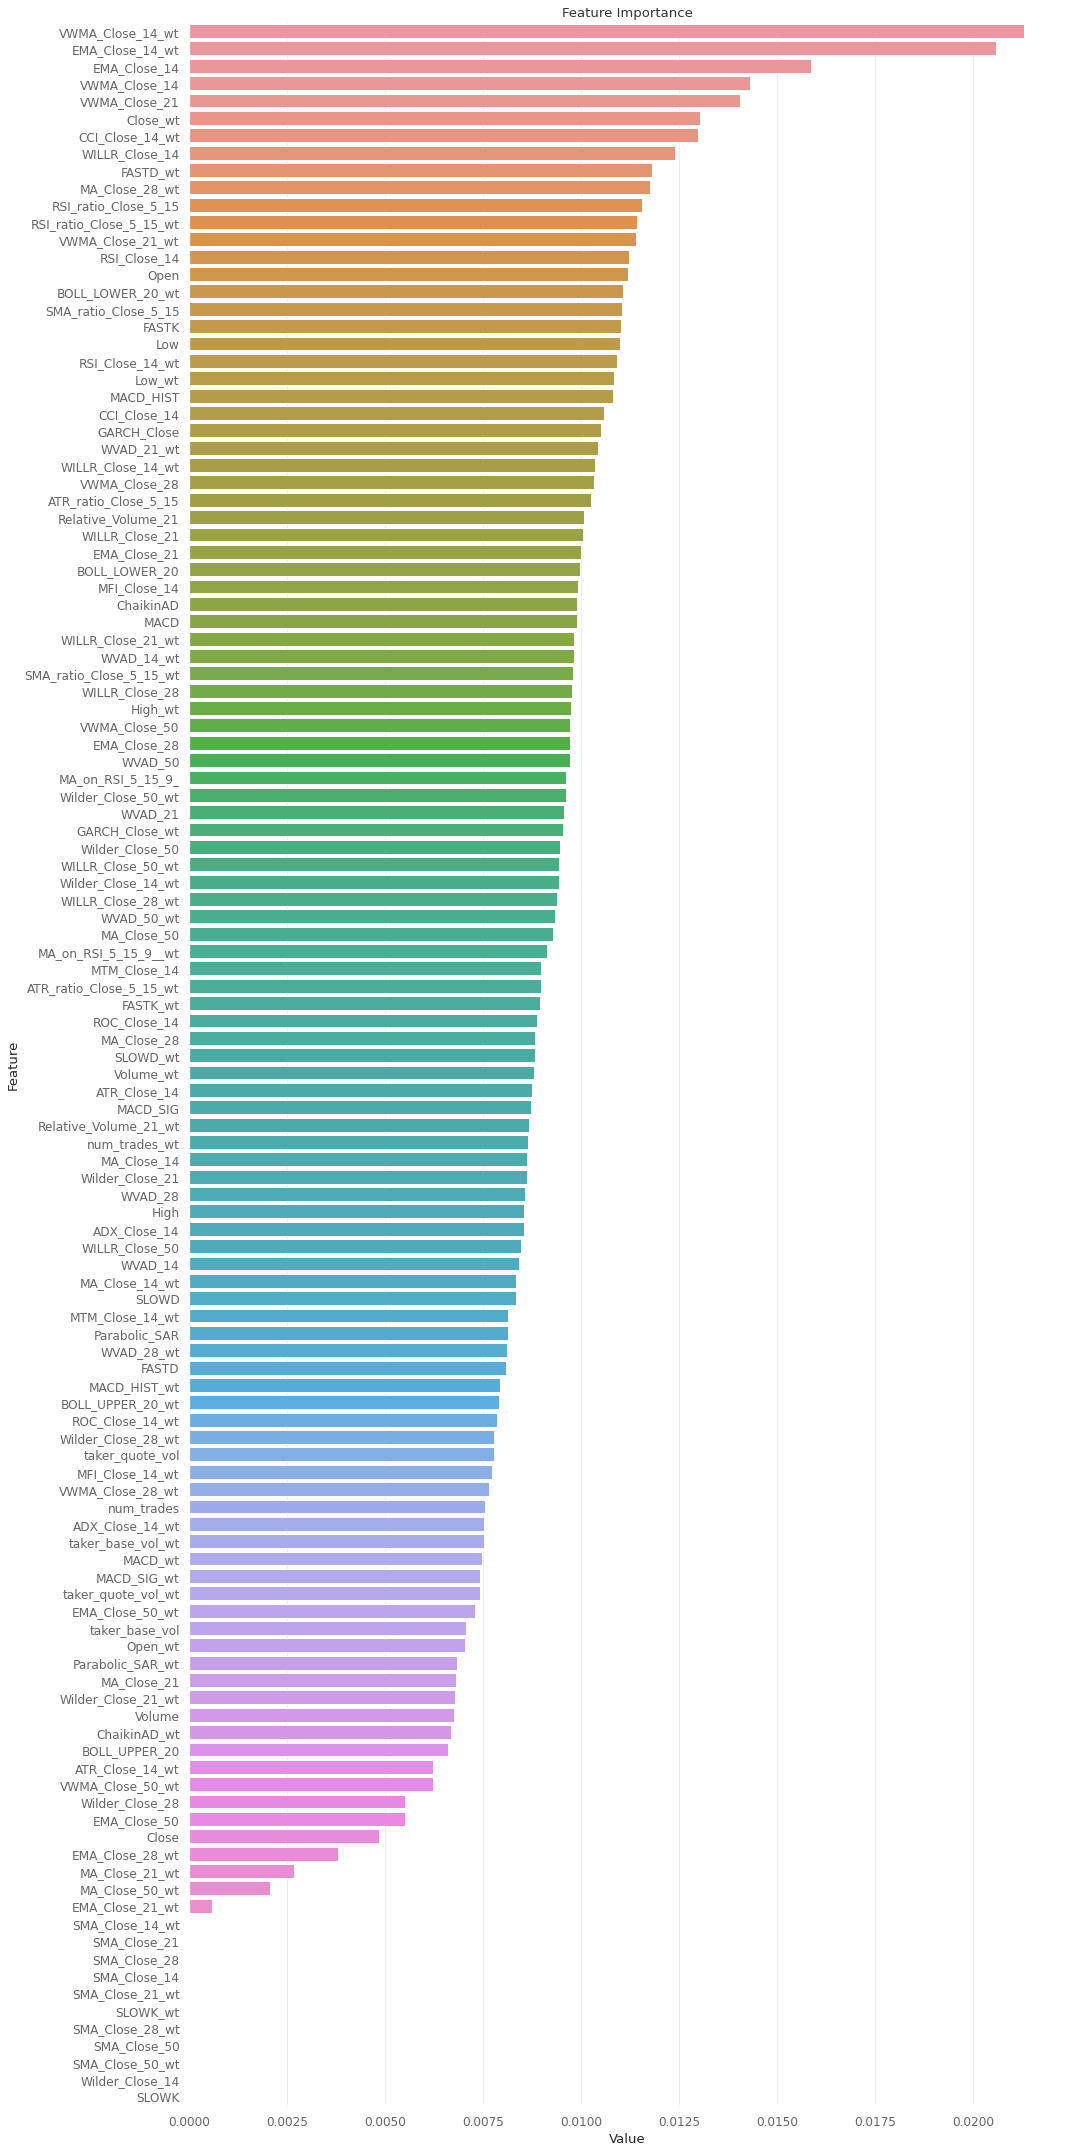

119           VWMA_Close_14_wt
118            EMA_Close_14_wt
117               EMA_Close_14
116              VWMA_Close_14
115              VWMA_Close_21
114                   Close_wt
113            CCI_Close_14_wt
112             WILLR_Close_14
111                   FASTD_wt
110             MA_Close_28_wt
109       RSI_ratio_Close_5_15
108    RSI_ratio_Close_5_15_wt
107           VWMA_Close_21_wt
106               RSI_Close_14
105                       Open
104           BOLL_LOWER_20_wt
103       SMA_ratio_Close_5_15
102                      FASTK
101                        Low
100            RSI_Close_14_wt
99                      Low_wt
98                   MACD_HIST
97                CCI_Close_14
96                 GARCH_Close
95                  WVAD_21_wt
Name: Feature, dtype: object


In [181]:
def ordered_feature_importances(X, y, feature_names=None):
    xgb = XGBClassifier(n_estimators=500)
    xgb.fit(X, y)

    if feature_names is None:
        feature_names = X.columns
    feature_imp = pd.DataFrame(
        sorted(zip(xgb.feature_importances_, feature_names)),
        columns=["Value", "Feature"],
    )
    return xgb, feature_imp.sort_values(by="Value", ascending=False)


estimators = []
for X, y in tqdm(train_datasets):
    estimator, ordered_features = ordered_feature_importances(
        X, y, feature_names=test_datapoints[0][interesting_tickers[0]]._features.columns
    )
    estimators.append(estimator)

plt.figure(figsize=(15, 30))
sns.barplot(
    x="Value",
    y="Feature",
    data=ordered_features,
)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()
print(ordered_features["Feature"].iloc[:25])


In [186]:
def create_base_datapoints(test_datapoints, estimator):
    for index, test_datapoint in enumerate(test_datapoints):
        if index == 0:
            base_datapoints = {
                ticker: deepcopy(dp) for ticker, dp in test_datapoint.items()
            }

            if len(estimator) > 1:
                for ticker, dp in test_datapoint.items():
                    base_datapoints[ticker].predictions = estimator[index].predict(
                        dp._features
                    )
                    base_datapoints[ticker].probabilities = estimator[
                        index
                    ].predict_proba(dp._features)[:, 1]

        else:
            for ticker, dp in test_datapoint.items():
                base_datapoints[ticker].df = pd.concat(
                    [base_datapoints[ticker].df, dp.df]
                )
                base_datapoints[ticker].labels = pd.concat(
                    [base_datapoints[ticker].labels, dp.labels]
                )
                base_datapoints[ticker]._features = pd.concat(
                    (base_datapoints[ticker]._features, dp._features)
                )

                if len(estimator) > 1:
                    base_datapoints[ticker].predictions = np.concatenate(
                        [
                            base_datapoints[ticker].predictions,
                            estimator[index].predict(dp._features),
                        ]
                    )
                    base_datapoints[ticker].probabilities = np.concatenate(
                        [
                            base_datapoints[ticker].probabilities,
                            estimator[index].predict_proba(dp._features)[:, 1],
                        ]
                    )
    for ticker, dp in base_datapoints.items():
        if len(estimator) == 1:
            base_datapoints[ticker].predictions = estimator[0].predict(dp._features)
            base_datapoints[ticker].probabilities = estimator[0].predict_proba(dp._features)[:, 1]
        _metrics = metrics.classification_metrics(
            base_datapoints[ticker].labels, base_datapoints[ticker].predictions
        )
        setattr(base_datapoints[ticker], "metrics", _metrics)
    return to_dataframe(base_datapoints)


def to_dataframe(base_datapoints):
    for ticker, dp in base_datapoints.items():
        if isinstance(dp.predictions, np.ndarray):
            base_datapoints[ticker].predictions = pd.DataFrame(
                dp.predictions, index=dp.labels.index, columns=["predictions"]
            )
        if hasattr(dp, "probabilities"):
            base_datapoints[ticker].predictions["probabilities"] = dp.probabilities
    return base_datapoints


base_datapoints = create_base_datapoints(test_datapoints, estimators)

_metrics, fig = plotting.classification_plot(
    base_datapoints, lag=1, interval=config["interval"], metrics=True
)
print(_metrics)
fig.show()


ValueError: Feature shape mismatch, expected: 120, got 8

In [187]:
probabilities = base_datapoints[interesting_tickers[0]].predictions["probabilities"]
labels = base_datapoints[interesting_tickers[0]].labels

fpr, tpr, thresholds = roc_curve(labels, probabilities)

df = pd.DataFrame({"fpr": fpr, "tpr": tpr}, index=thresholds)
df.index.name = "Thresholds"
df.columns.name = "Rate"

fig = go.Figure(
    go.Scatter(
        x=df["fpr"],
        y=df["tpr"],
        text=df.index,
    )
)
fig.update_layout(
    xaxis_title="fpr",
    yaxis_title="tpr",
)
fig.show()


In [188]:
def create_backtest_datapoints(test_datapoints, base_datapoints):
    for index, test_datapoint in enumerate(test_datapoints):
        if index == 0:
            backtest_datapoints = {
                ticker: deepcopy(dp) for ticker, dp in test_datapoint.items()
            }
        else:
            for ticker, dp in test_datapoint.items():
                backtest_datapoints[ticker].df = pd.concat(
                    [backtest_datapoints[ticker].df, dp.df]
                )
                backtest_datapoints[ticker].labels = pd.concat(
                    [backtest_datapoints[ticker].labels, dp.labels]
                )
                backtest_datapoints[ticker]._features = pd.concat(
                    (backtest_datapoints[ticker]._features, dp._features)
                )

    for ticker, dp in base_datapoints.items():
        labels_index = backtest_datapoints[ticker].labels.index
        backtest_datapoints[ticker].predictions = pd.DataFrame(
            {
                "predictions": [np.nan] * len(labels_index),
                "probabilities": [np.nan] * len(labels_index),
            },
            index=labels_index,
        )

        common_index_predictions = backtest_datapoints[
            ticker
        ].predictions.index.intersection(dp.predictions.index)

        backtest_datapoints[ticker].predictions.loc[
            common_index_predictions, "predictions"
        ] = dp.predictions.loc[common_index_predictions, "predictions"]
        
        backtest_datapoints[ticker].predictions.loc[
            common_index_predictions, "probabilities"
        ] = dp.predictions.loc[common_index_predictions, "probabilities"]
        backtest_datapoints[ticker].predictions =  backtest_datapoints[ticker].predictions.fillna(method="ffill")
        backtest_datapoints[ticker].predictions =  backtest_datapoints[ticker].predictions.fillna(0)
    return backtest_datapoints


vbt_config = copy.deepcopy(config)
vbt_config["interval"] = "6h"
vbt_config["ago"] = 4
vbt_inputs = [
    {
        "ticker": inp["ticker"],
        "beginning_date": inp[
            "beginning_date"
        ]
        - dataframe.convert_to_timedelta(vbt_config["interval"], ago=vbt_config["ago"]),
        "ending_date": inp["ending_date"],
    }
    for inp in inputs
]

dm = DataModule(
    vbt_config,
    compute_features=lambda x: (x, x["Open"]),
    inputs=vbt_inputs,
    save_klines=True,
)
train_datasets, val_datasets, test_datapoints = dm._init_train_val_data(
    dm.train_datapoints
)

backtest_datapoints = create_backtest_datapoints(test_datapoints, base_datapoints)


Last data index 2022-06-17 18:00:00+00:00
Last label index 2022-06-17 18:00:00+00:00
Last feature index 2022-06-17 18:00:00+00:00
NOT SHUFFLED
train_size: 4834, val_size: 2071, test_size: 0


In [189]:
vbt.settings.portfolio["fees"] = 0.001
vbt.settings.portfolio["slippage"] = 0.0025


data = vbt.Data.from_data(
    {dp.ticker: dp.df for dp in backtest_datapoints.values()},
    download_kwargs={},
)
# 
probabilities = vbt.Data.from_data(
    {dp.ticker: dp.predictions["probabilities"].to_frame(dp.ticker).shift(4) for dp in backtest_datapoints.values()},
    download_kwargs={},
)
predictions = pd.DataFrame(
    probabilities.get().values > 0.5,
    columns=probabilities.get().columns,
    index=probabilities.get().index,
)



In [190]:
sl_stop = 0.15
ohlcstcx = vbt.OHLCSTCX.run(
    entries=predictions,
    open=data.get("Open"),
    high=data.get("High"),
    low=data.get("Low"),
    close=data.get("Close"),
    sl_stop=sl_stop,
    sl_trail=True,
    tp_stop=3*sl_stop,
)

if len(ohlcstcx.exits.columns) == 1:
    exits = ~predictions | ohlcstcx.exits.loc[:, ohlcstcx.exits.columns[0]].to_frame(interesting_tickers[0])
entries =  ohlcstcx.entries


pf = vbt.Portfolio.from_signals(
    data.get("Open"),
    entries=entries,
    exits=exits,
    freq=timedelta(hours=1),
)
total_return = pf.total_return()
print(total_return)
pf.loc[total_return.sort_values(ascending=False).index[-1]].stats()

ohlcstcx_sl_stop  ohlcstcx_sl_trail  ohlcstcx_tp_stop     
0.15              True               0.45              BTC   -0.88153
Name: total_return, dtype: float64


Start                         2021-01-16 00:00:00+00:00
End                           2022-06-17 12:00:00+00:00
Period                                 86 days 07:00:00
Start Value                                       100.0
End Value                                     11.846966
Total Return [%]                             -88.153034
Benchmark Return [%]                         -42.913699
Max Gross Exposure [%]                            100.0
Total Fees Paid                                28.94949
Max Drawdown [%]                              91.451777
Max Drawdown Duration                  76 days 17:00:00
Total Trades                                        237
Total Closed Trades                                 237
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  39.662447
Best Trade [%]                                16.870606
Worst Trade [%]                              -18

In [191]:
pf.loc[total_return.sort_values(ascending=False).index[-1]].plot()

FigureWidget({
    'data': [{'legendgroup': '0',
              'line': {'color': '#1f77b4'},
              'na…

In [193]:
ohlcv_features = ["Open", "High", "Low", "Close", "Volume", "ChaikinAD"]

price_like_features = [
    "MA_Close_21",
    "MA_Close_21_wt",
    "MA_Close_50",
    "Close_wt",
    "EMA_Close_50_wt",
    "MA_Close_28_wt",
    "Open",
    "VWMA_Close_21_wt"
]

none_price_like_features = [
    "SLOWD_wt",
    "FASTK_wt",
    "FASTD_wt",
    "WILLR_Close_14",
    "FASTK",
    "MACD_SIG",
    "WILLR_Close_14_wt",
    "FASTD",
    "SLOWD",
    "RSI_ratio_Close_5_15_wt",
    "SMA_ratio_Close_5_15",
]
len(ohlcv_features) + len(price_like_features) + len(none_price_like_features)


25

In [194]:
def compute_important_features(data):
    features, labels = compute_features(data)
    features_ohlcv = features.loc[:, ohlcv_features]
    features_pl = features.loc[:, price_like_features]
    features_npl = features.loc[:, none_price_like_features]

    features = pd.concat([features_ohlcv, features_pl, features_npl], axis=1)
    return features, labels

dm = DataModule(
    config,
    compute_important_features,
    inputs,
    save_klines=True,
)
train_datasets, val_datasets, test_datapoints = dm._init_train_val_data(
    dm.train_datapoints
)

/home/matias/.pyenv/versions/3.9.8/envs/binance/lib/python3.9/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002949. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/home/matias/.pyenv/versions/3.9.8/envs/binance/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning:


The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.




Last data index 2022-06-17 20:00:00+00:00
Last label index 2022-06-17 20:00:00+00:00
Last feature index 2022-06-17 16:00:00+00:00
NOT SHUFFLED
train_size: 7201, val_size: 3086, test_size: 0


In [195]:
def sliding_dataset(features, timesteps, batch_size, shuffle=True, gan=True):
    temp_dataset = (
        tf.data.Dataset.from_tensor_slices(features)
        .window(timesteps, shift=1, drop_remainder=True)
        .flat_map(lambda x: x.batch(timesteps))
    )
    if gan:
        temp_dataset = temp_dataset.map(lambda x: (x, x))
    if shuffle:
        return temp_dataset.shuffle(
            len(features), reshuffle_each_iteration=True, seed=42
        ).batch(
            batch_size,
            drop_remainder=False,
            num_parallel_calls=tf.data.AUTOTUNE,
        )
    return temp_dataset.batch(
        batch_size,
        drop_remainder=False,
        num_parallel_calls=tf.data.AUTOTUNE,
    )


In [202]:
class AutoEncoder(Model):
    def __init__(self, num_input_features, config):
        super().__init__()
        self.num_input_features = num_input_features
        self.config = config

        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()

        self.compile(
            optimizer=tf.keras.optimizers.Adam(
                learning_rate=self.config["learning_rate"],
                decay=self.config["weight_decay"],
            ),
            loss="mse",
            metrics=["mae", "mse", "bce"],
        )

    def build_encoder(self):
        inputs = layers.Input(
            shape=(self.config["timesteps"], self.num_input_features),
        )
        # outputs = layers.Conv1D(9, 7, strides=1, padding="same")(inputs)
        # outputs = layers.BatchNormalization(axis=-1)(outputs)
        # outputs = layers.ReLU()(outputs)
        # outputs = layers.MaxPooling1D(2)(outputs)

        # outputs = layers.Conv1D(6, 7, strides=1, padding="same")(outputs)
        # outputs = layers.BatchNormalization(axis=-1)(outputs)
        # outputs = layers.ReLU()(outputs)
        # outputs = layers.MaxPooling1D(2)(outputs)

        # outputs = layers.UpSampling1D(size=2)(outputs)

        outputs = layers.Conv1D(3, 7, strides=1, padding="same")(inputs)
        outputs = layers.BatchNormalization(axis=-1)(outputs)
        outputs = layers.ReLU()(outputs)
        outputs = layers.MaxPooling1D(2)(outputs)

        return Model(inputs=inputs, outputs=outputs, name="encoder")

    def build_decoder(self):
        _, H, W = self.encoder.output.shape
        inputs = layers.Input(shape=(H, W))
        outputs = layers.Conv1D(
            6,
            7,
            strides=1,
            padding="same",
        )(inputs)
        outputs = layers.UpSampling1D(size=2)(outputs)

        outputs = layers.Conv1D(
            9,
            7,
            strides=1,
            padding="same",
        )(outputs)
        outputs = layers.MaxPooling1D(2)(outputs)

        outputs = layers.Conv1D(
            self.num_input_features,
            7,
            strides=1,
            padding="same",
        )(outputs)
        outputs = layers.UpSampling1D(size=2)(outputs)

        outputs = layers.Conv1D(self.num_input_features, 7, strides=1, padding="same")(
            outputs
        )
        return Model(inputs=inputs, outputs=outputs, name="decoder")

    def encode(self, klines):
        return self.encoder(klines)

    def decode(self, rep):
        return self.decoder(rep)

    def call(self, klines):
        return self.decoder(self.encoder(klines))


config_pl = copy.deepcopy(config)
config_pl["learning_rate"] = 0.00003
config_pl["timesteps"] = 24
config_pl["batch_size"] = 32
config_pl["weight_decay"] = 0.00


train_dataset_pl = sliding_dataset(
    train_datasets[0][0][
        :, len(ohlcv_features) : len(ohlcv_features) + len(price_like_features)
    ],
    config_pl["timesteps"],
    config_pl["batch_size"],
    shuffle=True,
)
val_dataset_pl = sliding_dataset(
    val_datasets[0][0][
        :, len(ohlcv_features) : len(ohlcv_features) + len(price_like_features)
    ],
    config_pl["timesteps"],
    config_pl["batch_size"],
    shuffle=True,
)


ae_pl = AutoEncoder(num_input_features=len(price_like_features), config=config_pl)
ae_pl.fit(x=train_dataset_pl, validation_data=val_dataset_pl, epochs=300, verbose=True)


Epoch 1/300
225/225 [==============================] - 8s 19ms/step - loss: 0.0563 - mae: 0.1749 - mse: 0.0563 - bce: 0.9275 - val_loss: 0.4344 - val_mae: 0.6297 - val_mse: 0.4344 - val_bce: 5.2432
Epoch 2/300
225/225 [==============================] - 5s 14ms/step - loss: 0.0252 - mae: 0.1134 - mse: 0.0252 - bce: 0.7903 - val_loss: 0.3706 - val_mae: 0.4984 - val_mse: 0.3706 - val_bce: 3.9150
Epoch 3/300
225/225 [==============================] - 4s 13ms/step - loss: 0.0156 - mae: 0.0879 - mse: 0.0156 - bce: 0.6450 - val_loss: 0.4022 - val_mae: 0.4887 - val_mse: 0.4022 - val_bce: 3.4594
Epoch 4/300
225/225 [==============================] - 4s 13ms/step - loss: 0.0107 - mae: 0.0724 - mse: 0.0107 - bce: 0.5283 - val_loss: 0.3918 - val_mae: 0.4807 - val_mse: 0.3918 - val_bce: 3.0574
Epoch 5/300
225/225 [==============================] - 5s 15ms/step - loss: 0.0079 - mae: 0.0616 - mse: 0.0079 - bce: 0.4501 - val_loss: 0.2968 - val_mae: 0.4125 - val_mse: 0.2968 - val_bce: 2.5269
Epoch 6/30

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


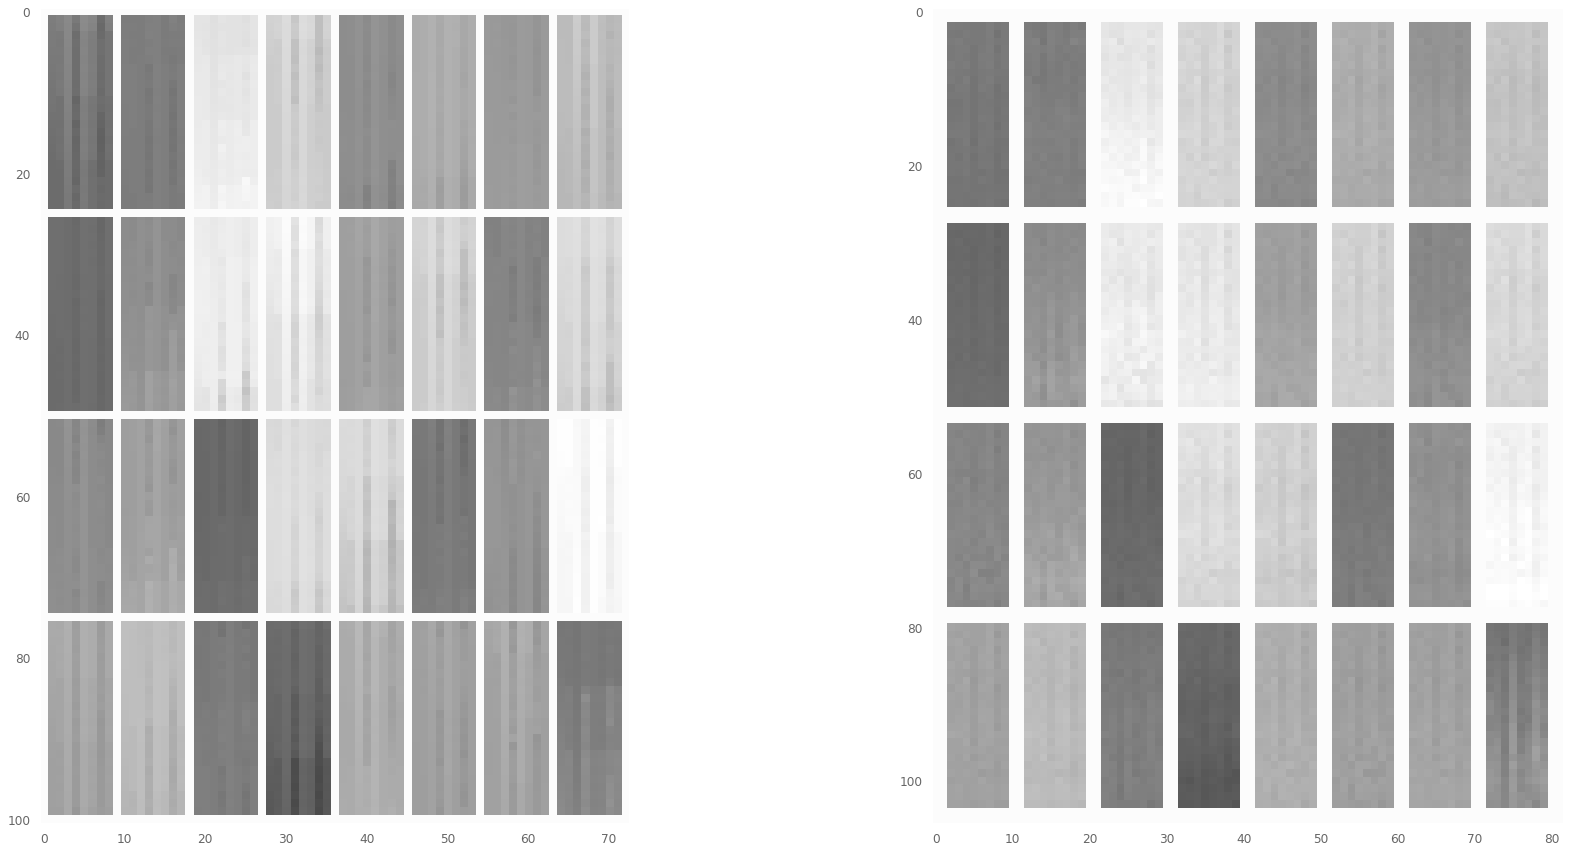

In [207]:
_, targets = next(iter(val_dataset_pl))
predictions = ae_pl(targets)

fig, axs = plt.subplots(1, 2, figsize=(30, 15))
grid_img = plotting.make_grid(
    tf.expand_dims(targets, 1), padding=1, pad_value=0.99
)
axs[0].imshow(grid_img.transpose(1, 2, 0))
axs[0].grid(False)

grid_img = plotting.make_grid(
    tf.expand_dims(predictions, 1), wpadding=1, pad_value=0.99
)
axs[1].imshow(grid_img.transpose(1, 2, 0))
axs[1].grid(False)

In [209]:
config_npl = copy.deepcopy(config_pl)
config_npl["learning_rate"] = 0.0001

train_dataset_npl = sliding_dataset(
    train_datasets[0][0][
        :,
        len(ohlcv_features)
        + len(price_like_features) : len(ohlcv_features)
        + len(price_like_features)
        + len(none_price_like_features),
    ],
    config_npl["timesteps"],
    config_npl["batch_size"],
    shuffle=True,
)
val_dataset_npl = sliding_dataset(
    val_datasets[0][0][
        :,
        len(ohlcv_features)
        + len(price_like_features) : len(ohlcv_features)
        + len(price_like_features)
        + len(none_price_like_features),
    ],
    config_npl["timesteps"],
    config_npl["batch_size"],
    shuffle=True,
)


ae_npl = AutoEncoder(
    num_input_features=len(none_price_like_features), config=config_npl
)
ae_npl.fit(x=train_dataset_npl, validation_data=val_dataset_npl, epochs=300, verbose=True)


Epoch 1/300
225/225 [==============================] - 5s 11ms/step - loss: 0.2818 - mae: 0.4258 - mse: 0.2818 - bce: 3.0452 - val_loss: 0.0786 - val_mae: 0.2199 - val_mse: 0.0786 - val_bce: 0.9373
Epoch 2/300
225/225 [==============================] - 3s 8ms/step - loss: 0.0797 - mae: 0.2237 - mse: 0.0797 - bce: 1.0598 - val_loss: 0.0701 - val_mae: 0.2100 - val_mse: 0.0701 - val_bce: 0.9999
Epoch 3/300
225/225 [==============================] - 2s 8ms/step - loss: 0.0525 - mae: 0.1810 - mse: 0.0525 - bce: 0.8251 - val_loss: 0.0602 - val_mae: 0.1942 - val_mse: 0.0602 - val_bce: 0.9533
Epoch 4/300
225/225 [==============================] - 2s 8ms/step - loss: 0.0399 - mae: 0.1572 - mse: 0.0399 - bce: 0.7484 - val_loss: 0.0456 - val_mae: 0.1685 - val_mse: 0.0456 - val_bce: 0.8240
Epoch 5/300
225/225 [==============================] - 2s 7ms/step - loss: 0.0324 - mae: 0.1414 - mse: 0.0324 - bce: 0.7114 - val_loss: 0.0384 - val_mae: 0.1543 - val_mse: 0.0384 - val_bce: 0.7782
Epoch 6/300
22

KeyboardInterrupt: 

In [210]:
_, targets = next(iter(val_dataset_npl))
predictions = ae_npl(targets)

fig, axs = plt.subplots(1, 2, figsize=(30, 15))
grid_img = plotting.make_grid(
    tf.expand_dims(targets, 1), padding=1, pad_value=0.99
)
axs[0].imshow(grid_img.transpose(1, 2, 0))
axs[0].grid(False)

grid_img = plotting.make_grid(
    tf.expand_dims(predictions, 1), padding=1, pad_value=0.99
)
axs[1].imshow(grid_img.transpose(1, 2, 0))
axs[1].grid(False)


In [161]:
preencoding_train_dataset_pl = sliding_dataset(
    train_datasets[0][0][
        :, len(ohlcv_features) : len(ohlcv_features) + len(price_like_features)
    ],
    config_pl["timesteps"],
    config_pl["batch_size"],
    shuffle=False,
)
preencoding_val_dataset_pl = sliding_dataset(
    val_datasets[0][0][
        :, len(ohlcv_features) : len(ohlcv_features) + len(price_like_features)
    ],
    config_pl["timesteps"],
    config_pl["batch_size"],
    shuffle=False,
)

preencoding_train_dataset_npl = sliding_dataset(
    train_datasets[0][0][
        :,
        len(ohlcv_features)
        + len(price_like_features) : len(ohlcv_features)
        + len(price_like_features)
        + len(none_price_like_features),
    ],
    config_npl["timesteps"],
    config_npl["batch_size"],
    shuffle=False,
)
preencoding_val_dataset_npl = sliding_dataset(
    val_datasets[0][0][
        :,
        len(ohlcv_features)
        + len(price_like_features) : len(ohlcv_features)
        + len(price_like_features)
        + len(none_price_like_features),
    ],
    config_npl["timesteps"],
    config_npl["batch_size"],
    shuffle=False,
)

encoded_train_dataset_pl = ae_pl.encoder.predict(preencoding_train_dataset_pl)
encoded_val_dataset_pl = ae_pl.encoder.predict(preencoding_val_dataset_pl)
encoded_train_dataset_npl = ae_npl.encoder.predict(preencoding_train_dataset_npl)
encoded_val_dataset_npl = ae_npl.encoder.predict(preencoding_val_dataset_npl)
print(
    f"Original pl shape: {next(iter(train_dataset_pl))[0].shape}, Encoded pl shape: {encoded_train_dataset_pl.shape}"
)
print(
    f"Original npl shape: {next(iter(train_dataset_npl))[0].shape}, Encoded npl shape: {encoded_train_dataset_npl.shape}"
)


25/25 [==============================] - 0s 3ms/step
Original pl shape: (32, 24, 8), Encoded pl shape: (1864, 12, 3)
Original npl shape: (32, 24, 11), Encoded npl shape: (1864, 12, 3)


#Create dataset for OHLCVs and define its dataloader


In [162]:
preencoding_train_dataset_ohlcv = sliding_dataset(
    train_datasets[0][0][
        :, :len(ohlcv_features)
    ],
    12,
    config_pl["batch_size"],
    shuffle=False,
    gan=False
).unbatch()
preencoding_val_dataset_ohlcv = sliding_dataset(
    val_datasets[0][0][
        :, :len(ohlcv_features)
    ],
    12,
    config_pl["batch_size"],
    shuffle=False,
    gan=False
).unbatch()

encoded_train_dataset_ohlcv = np.array(list(preencoding_train_dataset_ohlcv.as_numpy_iterator()))[12:]
encoded_val_dataset_ohlcv = np.array(list(preencoding_val_dataset_ohlcv.as_numpy_iterator()))[12:]
print(
    f"Encoded ohlcv shape: {encoded_train_dataset_ohlcv.shape}"
)

Encoded ohlcv shape: (1864, 12, 6)


In [168]:
train_dataset_labels = train_datasets[0][1][23:]
val_dataset_labels = val_datasets[0][1][23:]
print(
    f"labels shape: {train_dataset_labels.shape}"
)


labels shape: (1864,)


In [170]:
config_encoded = copy.deepcopy(config)
config_encoded["learning_rate"] = 0.0001
config_encoded["batch_size"] = 32


encoded_train_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            (
                encoded_train_dataset_ohlcv,
                encoded_train_dataset_pl,
                encoded_train_dataset_npl,
            ),
            train_dataset_labels,
        )
    )
    .shuffle(len(encoded_train_dataset_ohlcv), reshuffle_each_iteration=True, seed=42)
    .batch(
        config_encoded["batch_size"],
        drop_remainder=False,
        num_parallel_calls=tf.data.AUTOTUNE,
    )
)
encoded_val_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            (
                encoded_val_dataset_ohlcv,
                encoded_val_dataset_pl,
                encoded_val_dataset_npl,
            ),
            val_dataset_labels,
        )
    )
    .shuffle(len(encoded_val_dataset_ohlcv), reshuffle_each_iteration=True, seed=42)
    .batch(
        config_encoded["batch_size"],
        drop_remainder=False,
        num_parallel_calls=tf.data.AUTOTUNE,
    )
)
(ohlcv, pl, npl), label = next(iter(encoded_val_dataset))
ohlcv.shape, pl.shape, npl.shape, label.shape


(TensorShape([32, 12, 6]),
 TensorShape([32, 12, 3]),
 TensorShape([32, 12, 3]),
 TensorShape([32]))

In [179]:
class Estimator(Model):
    def __init__(
        self, features_ohlcv_shape, features_pl_shape, features_npl_shape, config
    ):
        super().__init__()
        self.config = config

        self.features_ohlcv_shape = features_ohlcv_shape[-2:]
        self.features_pl_shape = features_pl_shape[-2:]
        self.features_npl_shape = features_npl_shape[-2:]

        self.conv_ohlcv = self.build_conv_layers(
            self.features_ohlcv_shape, name="conv_ohlcv"
        )
        self.conv_pl = self.build_conv_layers(self.features_pl_shape, name="conv_pl")
        self.conv_npl = self.build_conv_layers(self.features_npl_shape, name="conv_npl")
        self.lstm_model = self.build_lstm_model()

        self.compile(
            optimizer=tf.keras.optimizers.Adam(
                learning_rate=self.config["learning_rate"],
                decay=self.config["weight_decay"],
            ),
            loss="bce",
            metrics="bce"
        )

    def build_conv_layers(self, input_shape, name):
        H, W = input_shape
        inputs = layers.Input(shape=(H, W))
        outputs = layers.Conv1D(
            20,
            5,
            strides=1,
            padding="same",
        )(inputs)
        outputs = layers.BatchNormalization(axis=-1)(outputs)
        outputs = layers.ReLU()(outputs)
        outputs = layers.MaxPooling1D(2)(outputs)

        outputs = layers.Conv1D(
            3,
            3,
            strides=1,
            padding="same",
        )(outputs)
        outputs = layers.BatchNormalization(axis=-1)(outputs)
        outputs = layers.ReLU()(outputs)
        return Model(inputs=inputs, outputs=outputs, name=name)

    def build_lstm_model(self):
        _, H, W_ohlcv = self.conv_ohlcv.output.shape
        _, _, W_pl = self.conv_pl.output.shape
        _, _, W_npl = self.conv_pl.output.shape
        W = W_ohlcv + W_pl + W_npl

        inputs = layers.Input(shape=(H, W))
        # outputs = layers.Permute((2, 1))(inputs)
        outputs = layers.LSTM(20)(inputs)
        outputs = layers.Flatten()(outputs)
        outputs = layers.Dense(10, activation="relu")(outputs)
        outputs = layers.Dense(1)(outputs)
        return Model(inputs=inputs, outputs=outputs, name="LSTM")

    def call(self, klines):
        conv_ohlcv = self.conv_ohlcv(klines[0])
        conv_pl = self.conv_pl(klines[1])
        conv_npl = self.conv_npl(klines[2])
        conv = tf.concat([conv_ohlcv, conv_pl, conv_npl], axis=-1)
        lstm = self.lstm_model(conv)
        return lstm


config_encoded["learning_rate"] = 0.0003
config_encoded["weight_decay"] = 0.01

estimator = Estimator(ohlcv.shape, pl.shape, npl.shape, config=config_encoded)
estimator.fit(
    x=encoded_train_dataset,
    validation_data=encoded_val_dataset,
    epochs=400,
)


Epoch 1/400
59/59 [==============================] - 3s 14ms/step - loss: 1.3527 - bce: 1.3527 - val_loss: 1.2662 - val_bce: 1.2662
Epoch 2/400
59/59 [==============================] - 0s 7ms/step - loss: 0.8860 - bce: 0.8860 - val_loss: 0.9451 - val_bce: 0.9451
Epoch 3/400
59/59 [==============================] - 0s 8ms/step - loss: 0.7956 - bce: 0.7956 - val_loss: 0.8179 - val_bce: 0.8179
Epoch 4/400
59/59 [==============================] - 0s 7ms/step - loss: 0.7477 - bce: 0.7477 - val_loss: 0.7632 - val_bce: 0.7632
Epoch 5/400
59/59 [==============================] - 0s 8ms/step - loss: 0.7238 - bce: 0.7238 - val_loss: 0.7569 - val_bce: 0.7569
Epoch 6/400
59/59 [==============================] - 0s 7ms/step - loss: 0.7091 - bce: 0.7091 - val_loss: 0.7905 - val_bce: 0.7905
Epoch 7/400
59/59 [==============================] - 0s 8ms/step - loss: 0.7002 - bce: 0.7002 - val_loss: 0.8401 - val_bce: 0.8401
Epoch 8/400
59/59 [==============================] - 0s 7ms/step - loss: 0.6985 - 

KeyboardInterrupt: 

#Sanity Check

In [ ]:
model = three_line_network(channel_dim_OHLCV=sample1.shape[-1],channel_dim_INDICATORS=sample2.shape[-1],channel_dim_OSCILLATORS=sample3.shape[-1],
                           conv1_kernel_num_OHLCV=sample1.shape[-1],conv1_kernel_size_OHLCV=5,conv2_kernel_num_OHLCV=sample1.shape[-1],conv2_kernel_size_OHLCV=3,
                           conv1_kernel_num_IND=sample2.shape[-1],conv1_kernel_size_IND=5,conv2_kernel_num_IND=sample2.shape[-1],conv2_kernel_size_IND=3,
                           conv1_kernel_num_OSC=sample3.shape[-1],conv1_kernel_size_OSC=5,conv2_kernel_num_OSC=sample3.shape[-1],conv2_kernel_size_OSC=3,
                           maxpool_kernel_size=2, max_pool_stride=2, input_size=12, lstm_hidden_size=20, lstm_num_layers=1, batch_size=batch_size, output_size=1)


In [ ]:
model.cuda()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [ ]:
sample1_=sample1.permute(0,2,1)
sample2_=sample2.permute(0,2,1)
sample3_=sample3.permute(0,2,1)

In [ ]:
for iter in range(4000):

  model.hidden = ((torch.zeros(model.lstm_num_layers, model.batch_size, model.lstm_hidden_size).cuda()),
                  (torch.zeros(model.lstm_num_layers, model.batch_size, model.lstm_hidden_size).cuda()))
  out = model(sample1_,sample2_.detach(),sample3_.detach())
  loss = criterion(out, label_sample)
  print(f"Loss: {loss}")
  
  optimizer.zero_grad()
  loss.backward()

  optimizer.step()

Loss: 0.7143325805664062
Loss: 0.7142444849014282
Loss: 0.7141567468643188
Loss: 0.7140692472457886
Loss: 0.713982105255127
Loss: 0.7138951420783997
Loss: 0.7138083577156067
Loss: 0.7137219905853271
Loss: 0.7136357426643372
Loss: 0.713549792766571
Loss: 0.7134641408920288
Loss: 0.7133786678314209
Loss: 0.7132933735847473
Loss: 0.7132083177566528
Loss: 0.7131237387657166
Loss: 0.7130390405654907
Loss: 0.7129535675048828
Loss: 0.7128682136535645
Loss: 0.7127828001976013
Loss: 0.7126975655555725
Loss: 0.7126041054725647
Loss: 0.7125277519226074
Loss: 0.7124597430229187
Loss: 0.7123926281929016
Loss: 0.7123364210128784
Loss: 0.7122881412506104
Loss: 0.7122437357902527
Loss: 0.7121998071670532
Loss: 0.7121562361717224
Loss: 0.7121203541755676
Loss: 0.7120844125747681
Loss: 0.7120490074157715
Loss: 0.7120113372802734
Loss: 0.7119718194007874
Loss: 0.7119309306144714
Loss: 0.7118880748748779
Loss: 0.7118428945541382
Loss: 0.7117971181869507
Loss: 0.7117522358894348
Loss: 0.7117128372192383
Lo

#Train the main model

In [ ]:
model = three_line_network(channel_dim_OHLCV=sample1.shape[-1],channel_dim_INDICATORS=sample2.shape[-1],channel_dim_OSCILLATORS=sample3.shape[-1],
                           conv1_kernel_num_OHLCV=sample1.shape[-1],conv1_kernel_size_OHLCV=5,conv2_kernel_num_OHLCV=sample1.shape[-1],conv2_kernel_size_OHLCV=3,
                           conv1_kernel_num_IND=sample2.shape[-1],conv1_kernel_size_IND=5,conv2_kernel_num_IND=sample2.shape[-1],conv2_kernel_size_IND=3,
                           conv1_kernel_num_OSC=sample3.shape[-1],conv1_kernel_size_OSC=5,conv2_kernel_num_OSC=sample3.shape[-1],conv2_kernel_size_OSC=3,
                           maxpool_kernel_size=2, max_pool_stride=2, input_size=12, lstm_hidden_size=20, lstm_num_layers=1, batch_size=batch_size, output_size=1)

model.cuda()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [ ]:
length = 0
for data in train_df_pl_AE_dataloader_final:
  length = length + len(data)

last_batch = length%batch_size
last_batch

6

In [ ]:
losses = []
model.train()

for i in tqdm(range(600)):

  for n,((seq_ohlcv,y_train),seq_ind,seq_osc) in enumerate(zip(train_df_ohlcv_dataloader_final, train_df_pl_AE_dataloader_final, train_df_npl_AE_dataloader_final)):
    
    if n==len(train_df_ohlcv_dataloader_final)-1:

      batch_size_ = last_batch

    else:

      batch_size_ = batch_size

    model.batch_size = batch_size_

    model.hidden = ((torch.zeros(model.lstm_num_layers, model.batch_size, model.lstm_hidden_size).cuda()),
                  (torch.zeros(model.lstm_num_layers, model.batch_size, model.lstm_hidden_size).cuda()))
    
    seq_ohlcv = seq_ohlcv.permute(0,2,1)
    seq_ind = seq_ind.permute(0,2,1).detach()
    seq_osc = seq_osc.permute(0,2,1).detach()

    
    y_pred = model(seq_ohlcv,seq_ind,seq_osc)
    loss = criterion(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  losses.append(loss)
  print(f"Epoch {i} Loss: {loss.item()}")

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 0 Loss: 0.7180598974227905
Epoch 1 Loss: 0.6993182897567749
Epoch 2 Loss: 0.6913599967956543
Epoch 3 Loss: 0.6889208555221558
Epoch 4 Loss: 0.6892522573471069
Epoch 5 Loss: 0.6881526708602905
Epoch 6 Loss: 0.6869113445281982
Epoch 7 Loss: 0.6863595247268677
Epoch 8 Loss: 0.686342179775238
Epoch 9 Loss: 0.6864644885063171
Epoch 10 Loss: 0.6868869662284851
Epoch 11 Loss: 0.6871131658554077
Epoch 12 Loss: 0.6870822310447693
Epoch 13 Loss: 0.6871674060821533
Epoch 14 Loss: 0.686223030090332
Epoch 15 Loss: 0.6867102384567261
Epoch 16 Loss: 0.6863549947738647
Epoch 17 Loss: 0.6857870817184448
Epoch 18 Loss: 0.6856282949447632
Epoch 19 Loss: 0.684926450252533
Epoch 20 Loss: 0.6863746643066406
Epoch 21 Loss: 0.6855915784835815
Epoch 22 Loss: 0.6856433749198914
Epoch 23 Loss: 0.6847320795059204
Epoch 24 Loss: 0.6846590042114258
Epoch 25 Loss: 0.6838001012802124
Epoch 26 Loss: 0.6826116442680359
Epoch 27 Loss: 0.6813282370567322
Epoch 28 Loss: 0.6805071830749512
Epoch 29 Loss: 0.6790261268

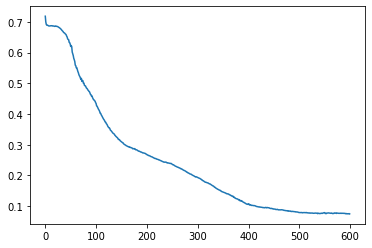

In [ ]:
plt.plot(losses)
plt.show()

#Evaluate the Model

In [ ]:
model.eval()


with torch.no_grad():

  for (seq_ohlcv,y_test),seq_ind,seq_osc in zip(test_df_ohlcv_dataloader_final, test_df_pl_AE_dataloader_final, test_df_npl_AE_dataloader_final):

    model.hidden = ((torch.zeros(model.lstm_num_layers, model.batch_size, model.lstm_hidden_size).cuda()),
                  (torch.zeros(model.lstm_num_layers, model.batch_size, model.lstm_hidden_size).cuda()))
    
    seq_ohlcv = seq_ohlcv.permute(0,2,1)
    seq_ind = seq_ind.permute(0,2,1).detach()
    seq_osc = seq_osc.permute(0,2,1).detach()

    model.batch_size = len(seq_ohlcv)
    model.hidden = ((torch.zeros(model.lstm_num_layers, model.batch_size, model.lstm_hidden_size)).cuda(),
                  (torch.zeros(model.lstm_num_layers, model.batch_size, model.lstm_hidden_size)).cuda())
    y_pred = model(seq_ohlcv,seq_ind,seq_osc)
    loss = criterion(y_pred, y_test)


#Trading Strategy

In [ ]:
y_test_ = np.array((y_test.cpu()).squeeze())
y_pred_ = np.array((y_pred.cpu()).squeeze())
close = test_df["close"][window_size:]
ret = (close.shift(-1) - close) / close

In [ ]:
def cfm(lower, upper):

  global clipped_y_test, clipped_y_pred, bet_sizing, clipped_ret

  clipped_y_test = np.array([])
  clipped_y_pred = np.array([])
  bet_sizing = np.array([])
  clipped_ret = np.array([])

  for i in range(len(y_pred_)-1):

    if y_pred_[i]<=lower:

      clipped_y_test = np.append(clipped_y_test, y_test_[i])
      clipped_y_pred = np.append(clipped_y_pred, 0)
      bet_sizing = np.append(bet_sizing, abs(y_pred_[i]-0.5))
      clipped_ret = np.append(clipped_ret, ret[i])

    elif y_pred_[i]>=upper:

      clipped_y_test = np.append(clipped_y_test, y_test_[i])
      clipped_y_pred = np.append(clipped_y_pred, 1)
      bet_sizing = np.append(bet_sizing, abs(y_pred_[i]-0.5))
      clipped_ret = np.append(clipped_ret, ret[i])

  cm = confusion_matrix(clipped_y_pred,clipped_y_test)
  make_confusion_matrix(cm, figsize=(10,8), cbar=True)


#Results

In [ ]:
cfm(lower=0.5, upper=0.5)


#profit saving
initial_margin = 100
margin = initial_margin
for i in range(len(bet_sizing)):

  position_size = bet_sizing[i] * initial_margin
  return_value = clipped_ret[i]
  side = 1 if clipped_y_test[i] == 1.0 else -1

  margin += position_size * return_value * side
pnl = 100*(margin - initial_margin) / initial_margin
print(f"Profit Saving -> Total PNL : {pnl}%")


#Use total balance for every positions
initial_margin = 100
margin = initial_margin
for i in range(len(bet_sizing)):

  position_size = bet_sizing[i] * margin
  return_value = clipped_ret[i]
  side = 1 if clipped_y_test[i] == 1.0 else -1

  margin += position_size * return_value * side
pnl = 100*(margin - initial_margin) / initial_margin
print(f"Without Profit Saving -> Total PNL : {pnl}%")

In [ ]:
cfm(lower=0.4, upper=0.6)


#profit saving
initial_margin = 100
margin = initial_margin
for i in range(len(bet_sizing)):

  position_size = bet_sizing[i] * initial_margin
  return_value = clipped_ret[i]
  side = 1 if clipped_y_test[i] == 1.0 else -1

  margin += position_size * return_value * side
pnl = 100*(margin - initial_margin) / initial_margin
print(f"Profit Saving -> Total PNL : {pnl}%")


#Use total balance for every positions
initial_margin = 100
margin = initial_margin
for i in range(len(bet_sizing)):

  position_size = bet_sizing[i] * margin
  return_value = clipped_ret[i]
  side = 1 if clipped_y_test[i] == 1.0 else -1

  margin += position_size * return_value * side
pnl = 100*(margin - initial_margin) / initial_margin
print(f"Without Profit Saving -> Total PNL : {pnl}%")

In [ ]:
cfm(lower=0.33, upper=0.66)

#profit saving
initial_margin = 100
margin = initial_margin
for i in range(len(bet_sizing)):

  position_size = bet_sizing[i] * initial_margin
  return_value = clipped_ret[i]
  side = 1 if clipped_y_test[i] == 1.0 else -1

  margin += position_size * return_value * side
pnl = 100*(margin - initial_margin) / initial_margin
print(f"Profit Saving -> Total PNL : {pnl}%")


#Use total balance for every positions
initial_margin = 100
margin = initial_margin
for i in range(len(bet_sizing)):

  position_size = bet_sizing[i] * margin
  return_value = clipped_ret[i]
  side = 1 if clipped_y_test[i] == 1.0 else -1

  margin += position_size * return_value * side
pnl = 100*(margin - initial_margin) / initial_margin
print(f"Without Profit Saving -> Total PNL : {pnl}%")

In [ ]:
cfm(lower=0.25, upper=0.75)

#profit saving
initial_margin = 100
margin = initial_margin
for i in range(len(bet_sizing)):

  position_size = bet_sizing[i] * initial_margin
  return_value = clipped_ret[i]
  side = 1 if clipped_y_test[i] == 1.0 else -1

  margin += position_size * return_value * side
pnl = 100*(margin - initial_margin) / initial_margin
print(f"Profit Saving -> Total PNL : {pnl}%")


#Use total balance for every positions
initial_margin = 100
margin = initial_margin
for i in range(len(bet_sizing)):

  position_size = bet_sizing[i] * margin
  return_value = clipped_ret[i]
  side = 1 if clipped_y_test[i] == 1.0 else -1

  margin += position_size * return_value * side
pnl = 100*(margin - initial_margin) / initial_margin
print(f"Without Profit Saving -> Total PNL : {pnl}%")

In [ ]:
cfm(lower=0.2, upper=0.8)

#profit saving
initial_margin = 100
margin = initial_margin
for i in range(len(bet_sizing)):

  position_size = bet_sizing[i] * initial_margin
  return_value = clipped_ret[i]
  side = 1 if clipped_y_test[i] == 1.0 else -1

  margin += position_size * return_value * side
pnl = 100*(margin - initial_margin) / initial_margin
print(f"Profit Saving -> Total PNL : {pnl}%")


#Use total balance for every positions
initial_margin = 100
margin = initial_margin
for i in range(len(bet_sizing)):

  position_size = bet_sizing[i] * margin
  return_value = clipped_ret[i]
  side = 1 if clipped_y_test[i] == 1.0 else -1

  margin += position_size * return_value * side
pnl = 100*(margin - initial_margin) / initial_margin
print(f"Without Profit Saving -> Total PNL : {pnl}%")